In [1]:
!git clone https://github.com/karpathy/minGPT.git
%cd minGPT
!pip install -e .

Cloning into 'minGPT'...


remote: Enumerating objects: 489, done.
remote: Total 489 (delta 0), reused 0 (delta 0), pack-reused 489
Receiving objects: 100% (489/489), 1.44 MiB | 7.75 MiB/s, done.
Resolving deltas: 100% (260/260), done.
/home/infres/acosta-23/ia321/minGPT
Obtaining file:///home/infres/acosta-23/ia321/minGPT
  Preparing metadata (setup.py) ... done
  Running setup.py develop for minGPT


Run the cell below JUST ONCE if you have just installed minGPT.

In [3]:
!pwd
%cd ..
# !pwd

/home/infres/acosta-23/ia321/minGPT
/home/infres/acosta-23/ia321
/home/infres/acosta-23/ia321


/home/infres/acosta-23/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
from aeon.datasets import load_classification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import random
import torch
import torch.nn as nn
from pyts.image import GramianAngularField

2024-03-20 01:14:09.521639: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 01:14:11.785500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
def load_dataset(PATH):
  loaded_data = np.load(PATH)
  X_train = loaded_data['X_train']
  X_test = loaded_data['X_test']
  y_train = loaded_data['y_train']
  y_test = loaded_data['y_test']
  indices = loaded_data['indices']
  X_train_deq = X_train[indices]
  y_train_deq = y_train[indices]

  return X_train, X_test, X_train_deq, y_train.reshape(y_train.shape[0]), y_test.reshape(y_test.shape[0]), y_train_deq.reshape(y_train_deq.shape[0])

gpds = load_dataset('../gunpoint.npz')
gpds[0].shape , gpds[3].shape

((160, 1, 150), (160,))

## 1.1 Preprocessing Data - BALANCED Dataset

### 1.1.1 Splitting Data

In [14]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test = gpds[0],gpds[1],gpds[3],gpds[4]

X_train = X_train.reshape(X_train.shape[0],X_train.shape[2],X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[2],X_test.shape[1])

X_train.shape, X_test.shape, type(X_train[0][0][0]), type(y_train[0])

((160, 150, 1), (40, 150, 1), numpy.float64, numpy.int64)

### 1.1.2 Transforming data to image.

Applying GASF transformation

(160, 150, 150) (40, 150, 150)


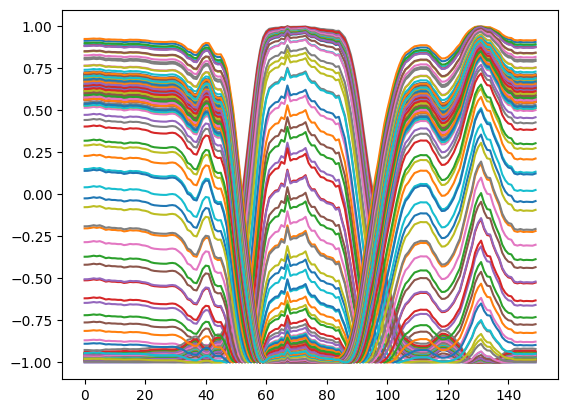

In [15]:
def transform_to_gasf(series,min_train,max_train):
    normalized_series = (series - min_train) / (max_train - min_train)
    gasf_transformer = GramianAngularField(image_size=normalized_series.shape[0], method='summation')
    gasf_image = gasf_transformer.fit_transform(normalized_series.reshape(1, -1))
    return gasf_image[0]

min_train = np.min([sample for sample in X_train])
max_train = np.max([sample for sample in X_train])

# Transform the entire dataset
X_train_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_train])
X_test_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_test])

print(X_train_gasf.shape , X_test_gasf.shape)
plt.plot(X_train_gasf[0])

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1.2 Pytorch minGPT

In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from mingpt.utils import set_seed

set_seed(42)

def extract_patches_from_batch(batch, patch_size=15):
    # batch is of shape (B, C, H, W)
    assert batch.size(1) % patch_size == 0 and batch.size(2) % patch_size == 0, "Image dimensions must be divisible by the patch size"
    
    patches = batch.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    
    # Calculate the number of patches
    num_patches = (batch.size(1) // patch_size) * (batch.size(2) // patch_size)
    
    patches = patches.contiguous().view(num_patches*batch.size(0), patch_size, patch_size)
    
    return patches

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y,patch_size=15):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

        self.patch_size = patch_size

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        img = img.unsqueeze(0)

        patches = extract_patches_from_batch(img, patch_size=self.patch_size)

        return patches, self.y[idx]
    

In [18]:
X_train_pytorch, X_val, y_train_pytorch, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

min_train = np.min([sample for sample in X_train_pytorch])
max_train = np.max([sample for sample in X_train_pytorch])

# Transform the entire dataset
X_train_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_train_pytorch])
X_val_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_val])
X_test_gasf = np.array([transform_to_gasf(sample, min_train, max_train) for sample in X_test])

# loading dataloader
train_dataset = TimeSeriesDataset(X_train_gasf, y_train)
val_dataset = TimeSeriesDataset(X_val_gasf, y_val)
test_dataset = TimeSeriesDataset(X_test_gasf, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [19]:
X_train_gasf.shape, y_train_pytorch, len(y_train_pytorch)

((128, 150, 150),
 array([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0]),
 128)

In [20]:
batch_x , batch_y = next(iter(train_loader))
batch_x.shape , batch_y.shape

(torch.Size([16, 100, 15, 15]), torch.Size([16]))

In [21]:
from mingpt.model import GPT

mconf = GPT.get_default_config()
mconf.model_type = 'gpt2'
mconf.vocab_size = 1600
mconf.block_size = 22500
model = GPT(mconf)

number of parameters: 103.56M


In [22]:
model(batch_x.reshape(16,22500))

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)